In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [8]:
file = pd.ExcelFile("food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0.  
We chose to focus on wheat, so we will be filtering the df accordingly.  
We also added columns with logarithmic transformations for yield, production, and hectares.

In [9]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
# df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
# df['log_hectares'] = np.log1p(df['production_tonnes'])
# df['log_production'] = np.log1p(df['hectares_ha'])
df = pd.get_dummies(df, columns=['national', 'subnational'])

<b>Random forest regressor:</b>
Here I train the random forest regressor and measure the preformance of the model.

In [17]:
# Features
X = df.drop(columns=['yield_tonnes_ha'])
# Target variable
y = df['yield_tonnes_ha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor for regression
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Absolute Error: 0.11652637827290396
Mean Squared Error: 0.03858925701428211
Root Mean Squared Error: 0.19644148496252545
R-squared: 0.9857974975146203


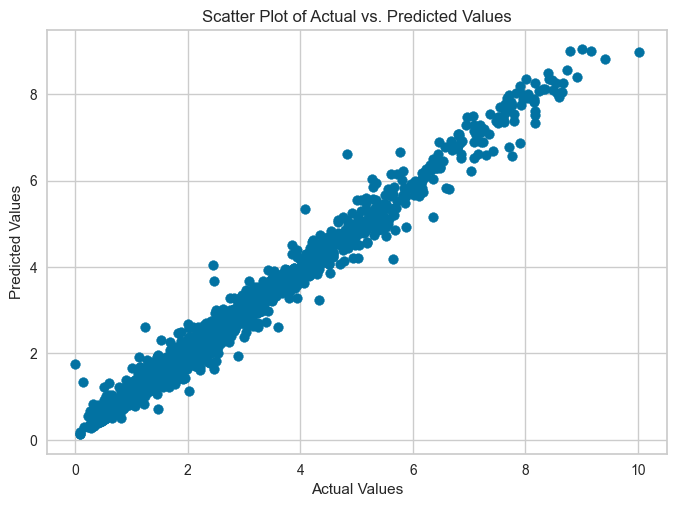

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Actual vs. Predicted Values")
plt.show()

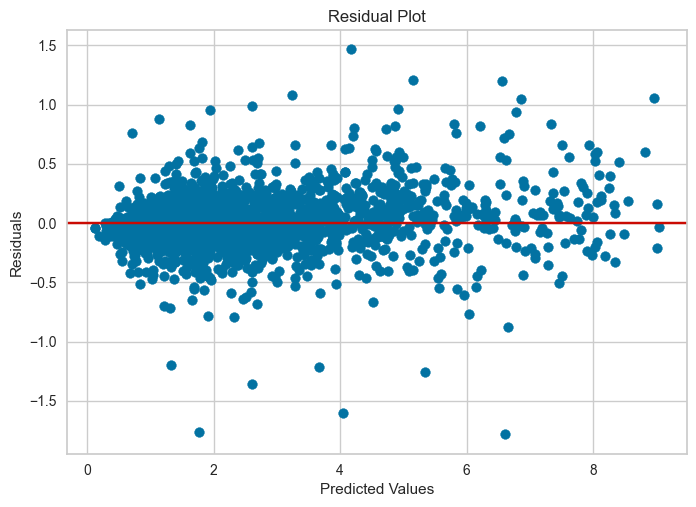

In [19]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()

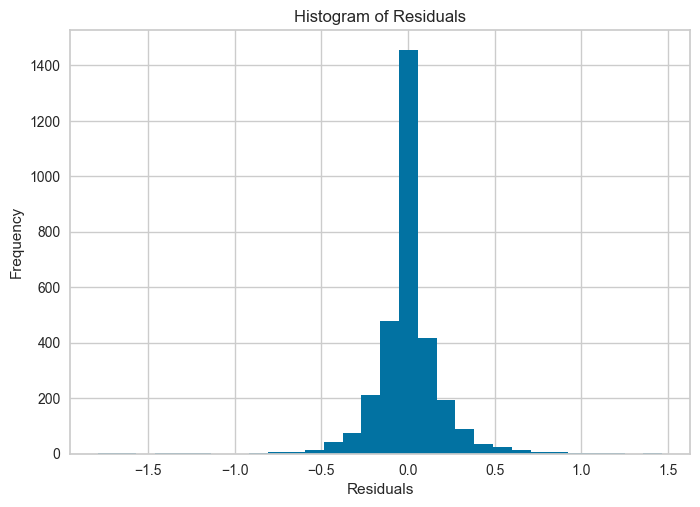

In [20]:
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

<b>Xgboost:</b>
Here I train the xgboost model and measure the preformance of the model.

In [21]:
# Features
X = df.drop(columns=['yield_tonnes_ha'])
# Target variable
y = df['yield_tonnes_ha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=100, random_state=42)

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Absolute Error: 0.13576666772597903
Mean Squared Error: 0.0458479443126458
Root Mean Squared Error: 0.2141213308212094
R-squared: 0.9831259891111948


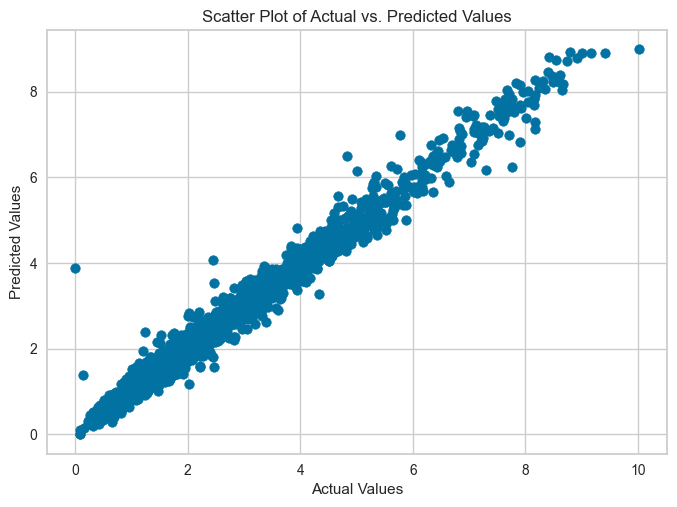

In [22]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Actual vs. Predicted Values")
plt.show()

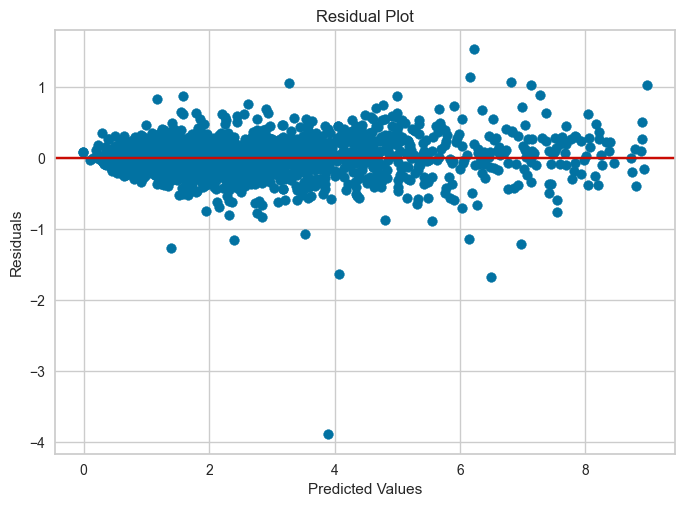

In [23]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()